In [21]:
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output

In [22]:
df_kodex = pd.read_excel("data_kodex_kospi_by_day.xlsx")
df_kodex

,DATE,TIME,DATETIME,KDX_OPN,KDX_CLS,KDX_HIGH,KDX_LOW,KDX_VOL
0,2018-05-18,18,2018051818,22944,22953,22953,22827,1759
1,2018-05-21,18,2018052118,22919,23013,23064,22836,5453
2,2018-05-23,18,2018052318,23013,23074,23110,22966,979327
3,2018-05-24,18,2018052418,23040,23022,23110,22901,2703
4,2018-05-25,18,2018052518,22859,22956,23018,22757,66231
...,...,...,...,...,...,...,...,...
995,2022-06-03,18,2022060318,27085,26960,27085,26925,41559
996,2022-06-07,18,2022060718,26830,26520,26865,26500,73223
997,2022-06-08,18,2022060818,26600,26550,26685,26520,24885
998,2022-06-09,18,2022060918,26485,26560,26560,26345,28349


In [23]:
df_kodex_inv = pd.read_excel("data_kodex_kospi_inverse_by_day.xlsx")
df_kodex_inv

,DATE,TIME,DATETIME,KDI_OPN,KDI_CLS,KDI_HIGH,KDI_LOW,KDI_VOL
0,2018-05-18,18,2018051818,6145,6135,6165,6135,5206379
1,2018-05-21,18,2018052118,6130,6135,6185,6115,5707844
2,2018-05-23,18,2018052318,6140,6090,6145,6090,5391745
3,2018-05-24,18,2018052418,6075,6115,6130,6075,3346092
4,2018-05-25,18,2018052518,6145,6095,6145,6090,5608692
...,...,...,...,...,...,...,...,...
995,2022-06-03,18,2022060318,4405,4420,4430,4395,14872251
996,2022-06-07,18,2022060718,4440,4500,4510,4440,24379235
997,2022-06-08,18,2022060818,4490,4490,4505,4465,16861667
998,2022-06-09,18,2022060918,4505,4495,4525,4485,19349290


In [24]:
df = df_kodex.merge(df_kodex_inv, how="left", on=["DATE", "TIME", "DATETIME"])
df.dropna(inplace=True)
df.sort_values("DATETIME", inplace=True)
df.reset_index(drop=True, inplace=True)
df["DATETIME"] = df["DATETIME"].astype(str)
split_no = int(len(df) * 0.8)

df_train = df[:split_no]
df_test = df[split_no:]
df_train

,DATE,TIME,DATETIME,KDX_OPN,KDX_CLS,KDX_HIGH,KDX_LOW,KDX_VOL,KDI_OPN,KDI_CLS,KDI_HIGH,KDI_LOW,KDI_VOL
0,2018-05-18,18,2018051818,22944,22953,22953,22827,1759,6145,6135,6165,6135,5206379
1,2018-05-21,18,2018052118,22919,23013,23064,22836,5453,6130,6135,6185,6115,5707844
2,2018-05-23,18,2018052318,23013,23074,23110,22966,979327,6140,6090,6145,6090,5391745
3,2018-05-24,18,2018052418,23040,23022,23110,22901,2703,6075,6115,6130,6075,3346092
4,2018-05-25,18,2018052518,22859,22956,23018,22757,66231,6145,6095,6145,6090,5608692
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2021-08-09,18,2021080918,32336,32218,32400,32164,118814,3735,3735,3755,3720,21445746
796,2021-08-10,18,2021081018,32238,32026,32321,31952,62361,3725,3760,3775,3725,19189233
797,2021-08-11,18,2021081118,31928,31839,32139,31839,44685,3775,3800,3800,3760,22052041
798,2021-08-12,18,2021081218,31834,31696,31933,31696,61519,3800,3815,3825,3790,23473506


In [53]:
from IPython.display import clear_output

class modelTrainer():

    def __init__(self, df, model_path="model_pred.h5", episodes=2000, profit_rate_goal=2, profit_rate_under_limit=0.9, egreedy=True):
        self.df = df
        self.model_path = model_path
        self.state_list = None
        self.action_names = ["X매수/I매도", "X매도/I매수", "홀드"]
        self.model_pred = None
        self.model_q = None
        self.episodes = episodes
        self.profit_rate_goal = profit_rate_goal #terminal 목표 수익율 설정
        self.profit_rate_under_limit = profit_rate_under_limit #terminal 하한선 설정
        self.egreedy = egreedy

    def makeStateList(self, before_range=60):
        state_list = []
        for idx in range(len(self.df)):
            if idx > before_range-1:
                this_mat = self.df.iloc[idx-before_range:idx, 2:].to_numpy() #DATETIME부터 마지막 열까지
                for col_idx in range(1, this_mat.shape[1]):
                    this_arr = this_mat[:, col_idx]
                    max_val = max(this_arr)
                    min_val = min(this_arr)
                    for row_idx, val in enumerate(this_arr):
                        new_val = (val - min_val) / (max_val - min_val)
                        this_mat[row_idx, col_idx] = new_val
                state_list.append(this_mat)

        self.state_list = np.array(state_list)

    def initModel(self):
        if os.path.exists(self.model_path) is False:
            self.model_pred = tf.keras.Sequential([
                tf.keras.layers.Input((self.state_list.shape[1]*(self.state_list.shape[2]-1))+4),
                tf.keras.layers.Dense(units=128, activation="relu"),
                tf.keras.layers.Dense(units=128, activation="relu"),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(units=128, activation="relu"),
                tf.keras.layers.Dense(units=128, activation="relu"),
                tf.keras.layers.Dense(units=len(self.action_names))
            ])
            self.model_pred.compile(optimizer=tf.keras.optimizers.Adam(), 
                        loss="mse", 
                        metrics=["mae", "mse"])

            self.model_pred.summary()
            self.model_pred.save(self.model_path)
            self.model_q = tf.keras.models.load_model(self.model_path)
        else:
            self.model_pred = tf.keras.models.load_model(self.model_path)
            self.model_q = tf.keras.models.load_model(self.model_path)
        
    def train(self):
        if self.model_pred is None or self.model_q is None:
            print("모델을 먼저 생성해 주세요!")
            return False
        self.capital = 1000 * 10000
        self.dis = .9 #discounted reward를 위해
        update_period = 240 #스테이지 240회당 1번씩 pred 모델의 웨이트를 업데이트 한다.
        copy_period = 360 #스테이지 360번당 q모델을 pred 모델에서 복제한다.
        cnt_for_update = 0
        cnt_for_copy = 0
        batch_buffer = []
        reward_list = []
        result = []
        for episode in range(1, self.episodes+1):
            clear_output(wait=True)
            
            #변수 초기화
            capital = self.capital #사전에 설정한 capital로 초기화
            self.remain_cash = capital
            self.remain_cash_kdx = 0
            self.remain_cash_kdi = 0
            self.remain_stock_kdx = 0
            self.remain_stock_kdi = 0
            this_max_profit = 0

            #exploration을 위해 에피소드 초기에는 랜덤하게 액션을 선택하게 한다.
            # e = 1. / (((episode*4) / 100) + 1)
            if self.egreedy is True:
                e = 1. / ((episode / 100) + 1)
            else:
                e = 0
            
            done = False

            for state_idx, state in enumerate(self.state_list):
                self.now_state = state
                cnt_for_update += 1
                cnt_for_copy += 1

                #update_period 횟수가 되면 pred 모델을 학습시키고 저장한다.
                if cnt_for_update+1 == update_period:
                    batch_buffer = np.array(batch_buffer, dtype=np.float64)
                    batch_buffer = batch_buffer.reshape(batch_buffer.shape[0], batch_buffer.shape[2])

                    reward_list = np.array(reward_list, dtype=np.float64)

                    self.model_pred = tf.keras.models.load_model(self.model_path)
                    self.model_pred.fit(batch_buffer, reward_list, verbose=0, batch_size=32)
                    try:
                        self.model_pred.save(self.model_path)
                    except:
                        time.sleep(5)
                        self.model_pred.save(self.model_path)
                    batch_buffer = [] #업데이트 한 후 미니배치(x)를 초기화한다.
                    reward_list = [] #업데이트 한 후 보상값(y)을 초기화한다.
                    cnt_for_update = 0

                #특정 시점(copy_period)가 되면 q모델을 pred모델로부터 복제해 온다.
                if cnt_for_copy+1 == copy_period:
                    self.model_q = tf.keras.models.load_model(self.model_path)
                    cnt_for_copy = 0

                #현재 스테이트의 정보를 불러온다. (60행 * 10열)
                state_data = state[:, 1:]

                #flatten => 600행
                state_data = state_data.reshape(state_data.shape[0]*state_data.shape[1])

                #현재 수익율(=잔고), kdx, kdi 잔고(비율)을 마지막 요소로 입력 => 603행
                remain_cash_sign = 0
                remain_kdx_sign = 0
                remain_kdi_sign = 0
                if self.remain_stock_kdx > 0:
                    remain_kdx_sign = 1.
                elif self.remain_stock_kdi > 0:
                    remain_kdi_sign = 1.
                else:
                    remain_cash_sign = 1.
                state_data = np.append(state_data, remain_cash_sign)
                state_data = np.append(state_data, remain_kdx_sign)
                state_data = np.append(state_data, remain_kdi_sign)
                state_data = np.append(state_data, (self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi)/self.capital)
                state_data = np.expand_dims(state_data, 0)
                state_data = state_data.astype(np.float32)
                batch_buffer.append(state_data) #pred 학습을 위해 먼저 미니배치 버퍼에 x를 넣어놓는다.

                #Q 모델에게 물어본다.
                pred = self.model_q.predict(state_data)
                action_selected = np.argmax(pred[0])
                action_name_org = self.action_names[action_selected] # 화면 출력용

                if np.random.rand(1) < e:
                    action_selected = random.randrange(0, 3)
                action_name_random = self.action_names[action_selected] # 화면 출력용

                #액션별 보상을 계산한다.
                reward, action_to_run = self._calcReward(action_selected)
                action_name_to_run = self.action_names[action_to_run] # 화면 출력용

                #보상을 reward_list에 반영한다. (y값이 될 것)
                reward_list.append(reward)

                #다음 스테이트 준비를 위해 액션을 취하고 액션별 수익을 갱신한다. (s+1 종가로 매수 / 매도 / 유지)
                self._updateRemain(action_to_run)

                if state_idx == len(self.state_list)-4: #마지막 스테이트라면 (실제로는 마지막 스테이트 -3이지만)
                    done = True
                else:
                    #수익율이 상한선에 다다르면 에피소드를 종료한다. 하한선에 다달았다면 reward를 -10으로 주고 에피소드를 종료한다.
                    if (self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi)/capital >= self.profit_rate_goal:
                        done = True
                    elif (self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi)/capital <= self.profit_rate_under_limit:
                        # reward[action_selected] = -10
                        done = True

                pred_print = [round(x, 3) for x in pred[0]]
                reward_print = [round(x, 3) for x in reward]
                print("[EPISODE{}, S{} : {} → {} → {}] {} {} {} 잔고 : {:,d}원 (현금 {:,d}원, KDX {:,d}원, KDI {:,d}원){}".format(
                    episode, state_idx, action_name_org, action_name_random, action_name_to_run, pred_print, reward_print,
                    " "*18, int(self.remain_cash+self.remain_cash_kdx+self.remain_cash_kdi), int(self.remain_cash),
                    int(self.remain_cash_kdx), int(self.remain_cash_kdi), " "*10), end="\r")
   
                if (self.remain_cash+self.remain_cash_kdx+self.remain_cash_kdi) > this_max_profit:
                    this_max_profit = (self.remain_cash+self.remain_cash_kdx+self.remain_cash_kdi)

                if done is True:
                    result.append({
                        "EPISODE" : episode,
                        "MAX. STATE" : state_idx,
                        "잔고" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi),
                        "수익" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi) - capital,
                        "수익율" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi) / capital,
                        "최고수익율" : this_max_profit / capital
                    })
                    break

            df_result = pd.DataFrame(result)
            df_result.to_excel("result.xlsx", index=False)

    def _updateRemain(self, action_to_run):
        # s+1의 데이터(df)를 불러온다
        s1_df_idx = self.df.loc[(df["DATETIME"] == self.now_state[-1, 0])].index[0] + 1
        s1_df = self.df.loc[s1_df_idx]
        if action_to_run == 0: #X매수/I매도라면
            #KDI 매도
            if self.remain_stock_kdi > 0:
                # 현재 들고 있는 KDI의 s+1 종가 기준으로 가치 계산
                profit = self.remain_stock_kdi * s1_df["KDI_CLS"]
                self.remain_cash = self.remain_cash + profit
            #KDX 매수
            stock_cnt = self.remain_cash // s1_df["KDX_CLS"] #살수 있는 주식 수
            stock_cash = s1_df["KDX_CLS"] * stock_cnt
            cash_rest = self.remain_cash % s1_df["KDX_CLS"]
            self.remain_cash = cash_rest
            self.remain_cash_kdx = stock_cash
            self.remain_cash_kdi = 0
            self.remain_stock_kdx = stock_cnt
            self.remain_stock_kdi = 0
        elif action_to_run == 1: #X매도/I매수라면
            #KDX 매도
            if self.remain_stock_kdx > 0:
                # 현재 들고 있는 KDX의 s+1 종가 기준으로 가치 계산
                profit = self.remain_stock_kdx * s1_df["KDX_CLS"]
                self.remain_cash = self.remain_cash + profit
            #KDI 매수
            stock_cnt = self.remain_cash // s1_df["KDI_CLS"] #살수 있는 주식 수
            stock_cash = s1_df["KDI_CLS"] * stock_cnt
            cash_rest = self.remain_cash % s1_df["KDI_CLS"]
            self.remain_cash = cash_rest
            self.remain_cash_kdx = 0
            self.remain_cash_kdi = stock_cash
            self.remain_stock_kdx = 0
            self.remain_stock_kdi = stock_cnt
        elif action_to_run == 2: #유지라면
            if self.remain_cash_kdx > 0:
                self.remain_cash_kdx = self.remain_stock_kdx * s1_df["KDX_CLS"]
            elif self.remain_cash_kdi > 0:
                self.remain_cash_kdi = self.remain_stock_kdi * s1_df["KDI_CLS"]
    
    # 보상설계가 핵심!
    def _calcProfit(self, stock_name_to_buy=None, action=None):
        # s+1, s+2, s+3의 데이터(df)를 불러온다
        s1_df_idx = self.df.loc[(df["DATETIME"] == self.now_state[-1, 0])].index[0] + 1
        s2_df_idx = self.df.loc[(df["DATETIME"] == self.now_state[-1, 0])].index[0] + 2
        s3_df_idx = self.df.loc[(df["DATETIME"] == self.now_state[-1, 0])].index[0] + 3
        s1_df = self.df.loc[s1_df_idx]
        s2_df = self.df.loc[s2_df_idx]
        s3_df = self.df.loc[s3_df_idx]

        if action == "HOLD":
            if self.remain_stock_kdx > 0:
                stock_name_to_hold = "KDX"
                capital_assume = self.remain_cash_kdx + self.remain_cash
            elif self.remain_stock_kdi > 0:
                stock_name_to_hold = "KDX"
                capital_assume = self.remain_cash_kdi + self.remain_cash
            else:
                capital_assume = self.remain_cash
                stock_name_to_hold = None

            if stock_name_to_hold is not None:
                stock_cnt_to_buy = capital_assume // s1_df[stock_name_to_hold+"_CLS"]
                s1_profit = (s2_df[stock_name_to_hold+"_CLS"] * stock_cnt_to_buy) - (s1_df[stock_name_to_hold+"_CLS"] * stock_cnt_to_buy)

                #s+2 종가에서 s+3 종가만큼의 차이만큼 수익이 있다고 계산한다.
                stock_cnt = capital_assume // s2_df[stock_name_to_hold+"_CLS"] #살수 있는 주식 수
                ca_rest = capital_assume % s2_df[stock_name_to_hold+"_CLS"]
                s3_profit = (stock_cnt * s3_df[stock_name_to_hold+"_CLS"]) + ca_rest
                max_profit = s1_profit + (self.dis * (capital_assume + s3_profit)) # --> 핵심이 될것!!!!!!!!!!!!!!!!!
            else:
                s1_profit = self.dis * capital_assume
                max_profit = s1_profit

        else:
            if stock_name_to_buy == "KDX":
                stock_name_to_sell = "KDI"
                capital_assume = self.remain_cash_kdi + self.remain_cash
                remain_of_stock = self.remain_stock_kdi
            elif stock_name_to_buy == "KDI":
                stock_name_to_sell = "KDX"
                capital_assume = self.remain_cash_kdx + self.remain_cash
                remain_of_stock = self.remain_stock_kdx

            #선택한 종목을 매수했을 경우의 수익
            stock_cnt_to_buy = capital_assume // s1_df[stock_name_to_buy+"_CLS"]
            s1_profit = (s2_df[stock_name_to_buy+"_CLS"] * stock_cnt_to_buy) - (s1_df[stock_name_to_buy+"_CLS"] * stock_cnt_to_buy)
            s1_profit = s1_profit - ((s1_df[stock_name_to_buy+"_CLS"] * stock_cnt_to_buy) * 0.00015) #거래 수수료 반영

            #반대 종목의 매도 수수료를 수익에서 차감
            s1_profit = s1_profit - ((remain_of_stock * s1_df[stock_name_to_sell+"_CLS"]) * 0.00015)

            # s+2의 max reward는?
            # case1 : s+1 KDX 종가에서 s+2 KDX 종가만큼의 차이만큼 수익이 있다고 계산한다.
            kdx_stock_cnt = capital_assume // s1_df["KDX_CLS"] #살수 있는 주식 수
            ca_rest = capital_assume % s1_df["KDX_CLS"]
            s2_profit_1 = (kdx_stock_cnt * s2_df["KDX_CLS"]) + ca_rest

            # case : s+1 KDI 종가에서 s+2 KDI 종가만큼의 차이만큼 수익이 있다고 계산한다.
            kdi_stock_cnt = capital_assume // s1_df["KDI_CLS"] #살수 있는 주식 수
            ca_rest = capital_assume % s1_df["KDI_CLS"]
            s2_profit_2 = (kdi_stock_cnt * s2_df["KDI_CLS"]) + ca_rest

            s2_profit = s2_profit_1
            if s2_profit_2 > s2_profit_1:
                s2_profit = s2_profit_2            
            max_profit = s1_profit + (self.dis * (capital_assume + s2_profit)) # --> 핵심이 될것!!!!!!!!!!!!!!!!!
        
        reward = max_profit / self.capital #reward 수치로 변환한다.
        
        return s1_profit, max_profit, reward

    def _calcReward(self, action_selected):
        _, _, a0_reward = self._calcProfit(stock_name_to_buy="KDX")
        _, _, a1_reward = self._calcProfit(stock_name_to_buy="KDI")
        _, _, a2_reward = self._calcProfit(action="HOLD")            
        reward_list = [a0_reward, a1_reward, a2_reward]
        argmax = np.argmax(reward_list)
        argmin = np.argmin(reward_list)
        
        reward_list[argmax] = 1
        reward_list[argmin] = -1

        for i in range(len(reward_list)):
            if i != argmax and i != argmin:
                reward_list[i] = 0

        a0_reward = reward_list[0]
        a1_reward = reward_list[1]
        a2_reward = reward_list[2]
        
        if action_selected == 0: #X매수/I매도라면
            if self.remain_stock_kdx > 0:
                reward_result = [-1, a1_reward, a2_reward]
                action_to_run = 2
                if a2_reward < a1_reward:
                    action_to_run = 1
            elif self.remain_stock_kdi > 0:
                reward_result = [a0_reward, -1, a2_reward]
                action_to_run = 0
            else:
                reward_result = [a0_reward, a1_reward, -1]
                action_to_run = 0
                if a0_reward < a1_reward:
                    action_to_run = 1

        elif action_selected == 1: #I매수/X매도라면
            if self.remain_stock_kdx > 0:
                reward_result = [-1, a1_reward, a2_reward]
                action_to_run = 1
            elif self.remain_stock_kdi > 0:
                reward_result = [a0_reward, -1, a2_reward]
                action_to_run = 2
                if a2_reward < a0_reward:
                    action_to_run = 0
            else:
                reward_result = [a0_reward, a1_reward, -1]
                action_to_run = 0
                if a0_reward < a1_reward:
                    action_to_run = 1
                
        elif action_selected == 2:
            if self.remain_stock_kdx > 0:
                reward_result = [-1, a1_reward, a2_reward]
                action_to_run = 2
            elif self.remain_stock_kdi > 0:
                reward_result = [a0_reward, -1, a2_reward]
                action_to_run = 2
            else:
                reward_result = [a0_reward, a1_reward, -1]
                action_to_run = 0
                if a0_reward < a1_reward:
                    action_to_run = 1

        return reward_result, action_to_run

In [55]:
trainer = modelTrainer(
    df_train,
    model_path="model_pred_220612_3actions.h5",
    episodes=1000,
    profit_rate_goal=10.0,
    profit_rate_under_limit=0.8,
    egreedy = True
)
trainer.makeStateList()
trainer.initModel()
trainer.train()

2022-06-12 12:20:27.627017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2022-06-12 12:20:38.906851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2022-06-12 12:20:43.516110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2022-06-12 12:20:58.932930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2022-06-12 12:21:00.730543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


: 

: 

# 추론 / 테스트 데이터에 적용

In [9]:
class Predictor(modelTrainer):
    def __init__(self, df, model_path):
        self.df = df
        self.state_list = None
        self.action_names = ["KDX매수", "KDX매도", "홀드", "KDI매수", "KDI매도"]
        self.model_q = tf.keras.models.load_model(model_path)

    def predict(self):
        if self.model_q is None:
            print("모델이 로드되지 않았습니다!")
            return False
        
        #변수 초기화
        result = []
        self.capital = 1000 * 10000
        self.remain_cash = self.capital
        self.remain_cash_kdx = 0
        self.remain_cash_kdi = 0
        self.remain_stock_kdx = 0
        self.remain_stock_kdi = 0
        self.dis = .9 #학습은 하지 않지만 reward 계산을 위해 필요..
        self.profit_rate_goal = 2. #terminal 목표 수익율 설정

        for state_idx, state in enumerate(self.state_list):
            self.now_state = state

            #현재 스테이트의 정보를 불러온다. (60행 * 10열)
            state_data = state[:, 1:]

            #flatten => 600행
            state_data = state_data.reshape(state_data.shape[0]*state_data.shape[1])

            #현재 수익율(=잔고), kdx, kdi 잔고(비율)을 마지막 요소로 입력 => 603행
            remain_cash_sign = 0
            remain_kdx_sign = 0
            remain_kdi_sign = 0
            if self.remain_stock_kdx > 0:
                remain_kdx_sign = 1.
            elif self.remain_stock_kdi > 0:
                remain_kdi_sign = 1.
            else:
                remain_cash_sign = 1.
            state_data = np.append(state_data, remain_cash_sign)
            state_data = np.append(state_data, remain_kdx_sign)
            state_data = np.append(state_data, remain_kdi_sign)
            state_data = np.expand_dims(state_data, 0)
            state_data = state_data.astype(np.float32)

            #Q 모델에게 물어본다.
            pred = self.model_q.predict(state_data)
            action_selected = np.argmax(pred[0])
            action_name_org = self.action_names[action_selected] # 화면 출력용

            #액션별 보상을 계산한다.
            reward, action_to_run = self._calcReward(action_selected)
            action_name_to_run = self.action_names[action_to_run] # 실제 실행할 액션

            #보상을 reward_list에 반영한다. (y값이 될 것)
            # reward_list.append(reward)

            #다음 스테이트 준비를 위해 액션을 취하고 액션별 수익을 갱신한다. (s+1 시가로 매수 / 매도 / 유지)
            self._updateRemain(action_to_run)

            if state_idx == len(self.state_list)-4: #마지막 스테이트라면 (실제로는 마지막 스테이트 -3이지만)
                break

            pred_print = [round(x, 2) for x in pred[0]]
            reward_print = [round(x, 2) for x in reward]
            print("[S{} : {}] {} {} {} 잔고 : {:,d}원 (현금 {:,d}원, KDX {:,d}원, KDI {:,d}원){}".format(
                state_idx, action_name_to_run, pred_print, reward_print,
                " "*40, int(self.remain_cash+self.remain_cash_kdx+self.remain_cash_kdi), int(self.remain_cash),
                int(self.remain_cash_kdx), int(self.remain_cash_kdi), " "*10), end="\r")

            result.append({
                "액션" : action_name_org,
                "액션(실행)" : action_name_to_run,
                "잔고" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi),
                "현금" : int(self.remain_cash),
                "KDX" : int(self.remain_cash_kdx),
                "KDI" : int(self.remain_cash_kdi),
                "수익" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi) - self.capital,
                "수익율" : int(self.remain_cash + self.remain_cash_kdx + self.remain_cash_kdi) / self.capital
            })

        self.df_result = pd.DataFrame(result)
        self.df_result.to_excel("result_pred.xlsx", index=False)

# df_test = df[400:]
df_test = df[split_no:]
predictor = Predictor(df_test, "model_pred_220611_3actions.h5")
predictor.makeStateList()
predictor.predict()

In [10]:
predictor.df_result

,액션,액션(실행),잔고,현금,KDX,KDI,수익,수익율
0,KDX매수,KDX매수,10000000,17030,9982970,0,0,1.000000
1,KDX매수,홀드,10021830,17030,10004800,0,21830,1.002183
2,KDX매수,홀드,9965220,17030,9948190,0,-34780,0.996522
3,KDX매수,홀드,9965220,17030,9948190,0,-34780,0.996522
4,KDX매수,홀드,9977800,17030,9960770,0,-22200,0.997780
...,...,...,...,...,...,...,...,...
166,KDX매수,홀드,9871980,17030,9854950,0,-128020,0.987198
167,KDX매수,홀드,9868280,17030,9851250,0,-131720,0.986828
168,KDX매수,홀드,9986680,17030,9969650,0,-13320,0.998668
169,KDX매수,홀드,9957080,17030,9940050,0,-42920,0.995708


1.46875

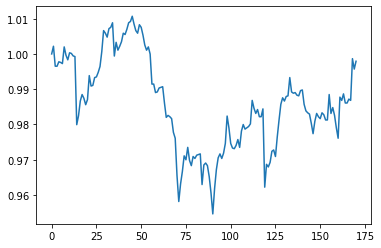

In [11]:
predictor.df_result["수익율"].plot()
len(df_test)/8/20